In [ ]:
conda create -n fastai python=3.7

conda activate fastai

conda install jupyter notebook
conda install -c conda-forge jupyter_contrib_nbextensions

conda install fastai pytorch=1.0.0 -c fastai -c pytorch -c conda-forge


conda install nb_conda_kernels
python -m ipykernel install --user --name fastai --display-name "fastai v1"
conda install ipywidgets


python -m fastai.utils.show_install


## IMDB Review Classification
https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb

The basic steps are:
1. Create (or, preferred, download a pre-trained) *language model* trained on a large corpus such as Wikipedia (a "language model" is any model that learns to predict the next word of a sentence)
2. Fine-tune this language model using your *target corpus* (in this case, IMDb movie reviews)
3. Remove the *encoder* in this fine tuned language model, and replace it with a *classifier*. Then fine-tune this model for the final classification task (in this case, sentiment analysis).

In [1]:
from fastai.text import *

In [2]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[WindowsPath('C:/Users/Luke/.fastai/data/imdb_sample/data_save.pkl'),
 WindowsPath('C:/Users/Luke/.fastai/data/imdb_sample/texts.csv')]

In [3]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [4]:
# Sample
df['text'][1][:500]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus a'


It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:
    

In [5]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [6]:
data_lm.save()

In [7]:
data = load_data(path)

### Tokenization
The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

we need to take care of punctuation
some words are contractions of two different words, like isn't or don't
we may need to clean some parts of our texts, if there's HTML code for instance
To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [8]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive


* the "'s" are grouped together in one token
* the contractions are separated like this: "did", "n't"
* content has been cleaned for any HTML symbol and lower cased
* there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization into `vocab`

* Creating unique tokens for all the words
* Top 60,000 used - unknown token `xxunk` used for remainders

In [9]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [10]:
data.train_ds[0][0]

Text xxbos xxmaj on xxup mtv xxunk all the xxunk and shot xxunk pull the classic movie xxmaj scarface out of their xxup dvd collection . xxmaj this may give you an idea that xxmaj scarface is a " gangster movie " . xxmaj sure , there are gangsters and xxunk in it , but that 's not the point of xxmaj scarface . xxmaj tony xxmaj montana ( xxmaj al xxmaj pacino ) is just a cuban xxunk looking for a new way of life . xxmaj he falls in with the mob group and becomes a well - known drug lord . xxmaj montana was all for doing what you wanted to do with your life . xxmaj the classic phrase : " xxmaj say hello to my little friend ! " is in xxmaj scarface . xxmaj this quote is what always comes to mind when i think about xxmaj brian xxunk movie , xxmaj scarface . xxmaj this falls under my top 10 favorite movies . i would rate it * * * 1 / 2 ( out of xxrep 4 * ) . xxmaj definitely a movie you must see . xxup phenomenal .

In [11]:
# Replacing tokens with their index

data.train_ds[0][0].data[:10]

array([   2,    5,   35,    6, 2516,    0,   46,    9,    0,   12], dtype=int64)

### Create Datablock

In [12]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

### Language Model
* Model pretrained on a cleaned subset of wikipedia called `wikitext-103`.
* That model has been trained to guess what the next word is, its input being all the previous words.

In [13]:
# Decrease batchsize if GPU can't handle the load

bs=12         # bs=48 originally

In [14]:
path = untar_data(URLs.IMDB)
path.ls()

[WindowsPath('C:/Users/Luke/.fastai/data/imdb/data_lm.pkl'),
 WindowsPath('C:/Users/Luke/.fastai/data/imdb/imdb.vocab'),
 WindowsPath('C:/Users/Luke/.fastai/data/imdb/models'),
 WindowsPath('C:/Users/Luke/.fastai/data/imdb/README'),
 WindowsPath('C:/Users/Luke/.fastai/data/imdb/test'),
 WindowsPath('C:/Users/Luke/.fastai/data/imdb/tmp_clas'),
 WindowsPath('C:/Users/Luke/.fastai/data/imdb/tmp_lm'),
 WindowsPath('C:/Users/Luke/.fastai/data/imdb/train'),
 WindowsPath('C:/Users/Luke/.fastai/data/imdb/unsup')]

In [15]:
(path/'train').ls()

[WindowsPath('C:/Users/Luke/.fastai/data/imdb/train/labeledBow.feat'),
 WindowsPath('C:/Users/Luke/.fastai/data/imdb/train/neg'),
 WindowsPath('C:/Users/Luke/.fastai/data/imdb/train/pos'),
 WindowsPath('C:/Users/Luke/.fastai/data/imdb/train/unsupBow.feat')]

In [16]:
# run from here overnight

In [17]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

* stored in `~/.fastai/models/ `

In [18]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [19]:
data_lm.show_batch()

idx,text
0,"later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj"
1,"xxmaj in the book the story is set near xxmaj dresden , which xxmaj krabat visits one time with his master and also he visits some nearby villages for festivities . ( xxmaj this part might have been changed to cut costs . ) i also do n't understand why in the movie the mill is located in the hills while the nearby graveyard is set in the high mountains"
2,"xxmaj betty . xxmaj she is a xxmaj kansas waitress who falls under a trance , and thinks she is a real life character of her favorite soap opera . xxmaj because of this , she goes on a journey to xxmaj los xxmaj angeles to reunite with her supposed soap opera character lover xxmaj dr. xxmaj rubell . xxmaj to add fuel to the fire , she is also"
3,""" of xxmaj bogart , xxmaj bacall , xxmaj huston , and other xxmaj hollywood personalities , contact me by e - mail . xxbos i enjoyed the first reviewer 's comment far more than i did the film when i saw it at a second - run theatre in the early ' 80 's . i was impressed then by the care taken to create costumes modelled so closely"
4,"not love it ? xxmaj cary xxmaj grant , xxmaj jayne xxmaj mansfield , xxmaj stanley xxmaj donen ; all icons in their own way . xxmaj however , the train wreck that was xxmaj suzy xxmaj parker ruined the entire experience for me . xxmaj her acting was so appalling that i sat there with my jaw hanging open , not believing my eyes or ears . i could"


In [20]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [21]:
# Learning rate finder
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


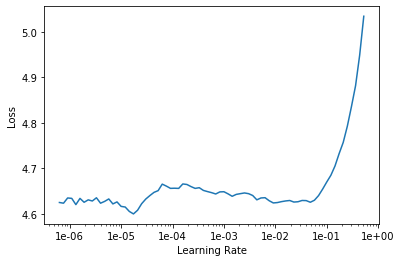

In [22]:
learn.recorder.plot(skip_end=15)

In [23]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.575081,4.400829,0.275646,2:38:18


In [24]:
learn.save('fit_head')

In [25]:
learn.load('fit_head');

* To complete the fine-tuning, we can then unfeeze and launch a new training.
* Takes 3hrs on a decent GPU

In [26]:
learn.unfreeze()

In [27]:
# Run overnight
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.094035,4.052074,0.311628,3:00:05
1,4.111072,4.055733,0.315332,3:00:07
2,4.098705,4.021856,0.318425,3:00:06


KeyboardInterrupt: 

In [28]:
learn.save('fine_tuned')

In [29]:
learn.load('fine_tuned');

How good is our model? Well let's try to see what it predicts after a few given words.

In [30]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [31]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it had a very great cast . i really like this movie and i really loved the idea . i liked it so much . The movie is about an alcoholic who is trying to do some research on
I liked this movie because i had loved it and i love it . It is a movie that will be in the same explode . The story is great , the characters are excellent and especially Richard N't .


In [ ]:
learn.save_encoder('fine_tuned_enc')

### Classifier
* Takes a bit of time on a GPU

In [ ]:
path = untar_data(URLs.IMDB)

In [ ]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [ ]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
data_clas.show_batch()

In [ ]:
# Create model

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

In [ ]:
learn.save('first')

In [ ]:
learn.load('first')

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn.save('second')
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn.predict("I really loved that movie, it was awesome!")